
--- Optimization for Rosenbrock ---


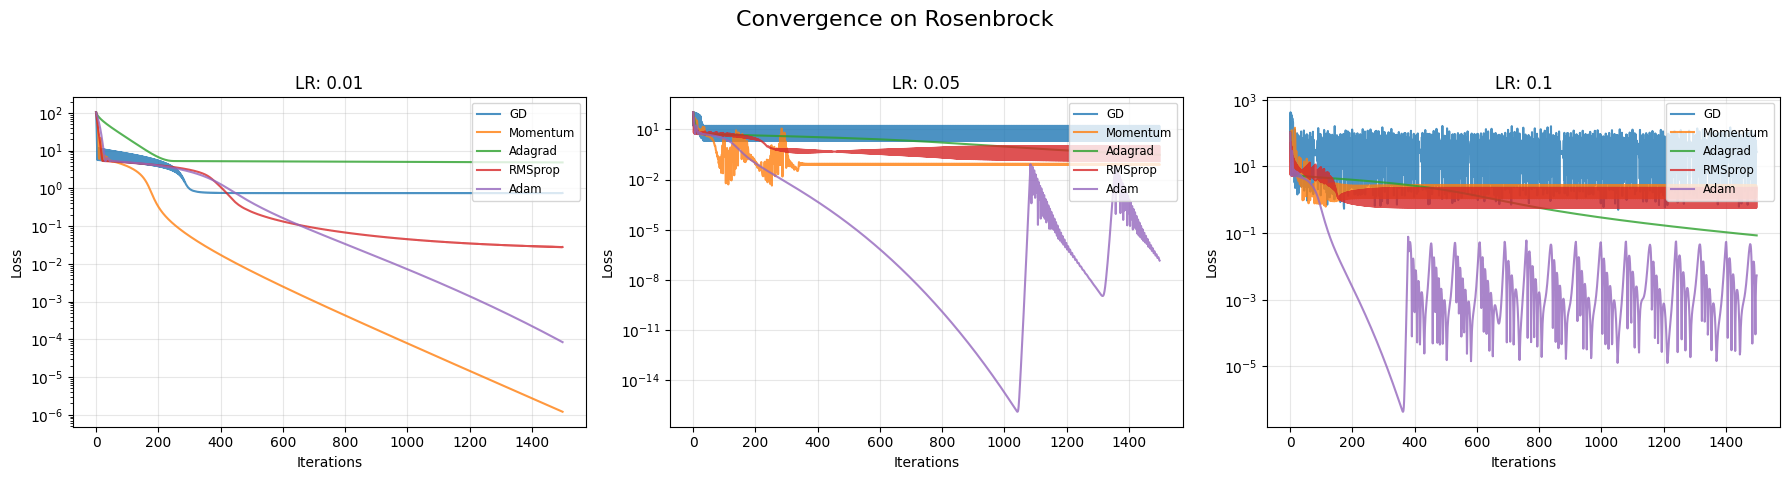

Optimizer  | LR    | Loss       | Result
--------------------------------------------------
GD         | 0.01  | 0.7551     | [0.535 0.214]
Momentum   | 0.01  | 0.0000     | [0.999 0.998]
Adagrad    | 0.01  | 4.8839     | [-1.209  1.468]
RMSprop    | 0.01  | 0.0279     | [0.917 0.826]
Adam       | 0.01  | 0.0001     | [0.991 0.982]
GD         | 0.05  | 2.1339     | [0.04  0.391]
Momentum   | 0.05  | 0.0775     | [0.947 0.868]
Adagrad    | 0.05  | 0.2980     | [0.455 0.205]
RMSprop    | 0.05  | 0.1271     | [0.73 0.63]
Adam       | 0.05  | 0.0000     | [1.    0.999]
GD         | 0.1   | 26.9869    | [0.171 0.463]
Momentum   | 0.1   | 2.5133     | [0.196 0.107]
Adagrad    | 0.1   | 0.0851     | [0.709 0.501]
RMSprop    | 0.1   | 2.2806     | [0.354 0.166]
Adam       | 0.1   | 0.0053     | [0.992 0.99 ]

--- Optimization for Sin(1_x) ---


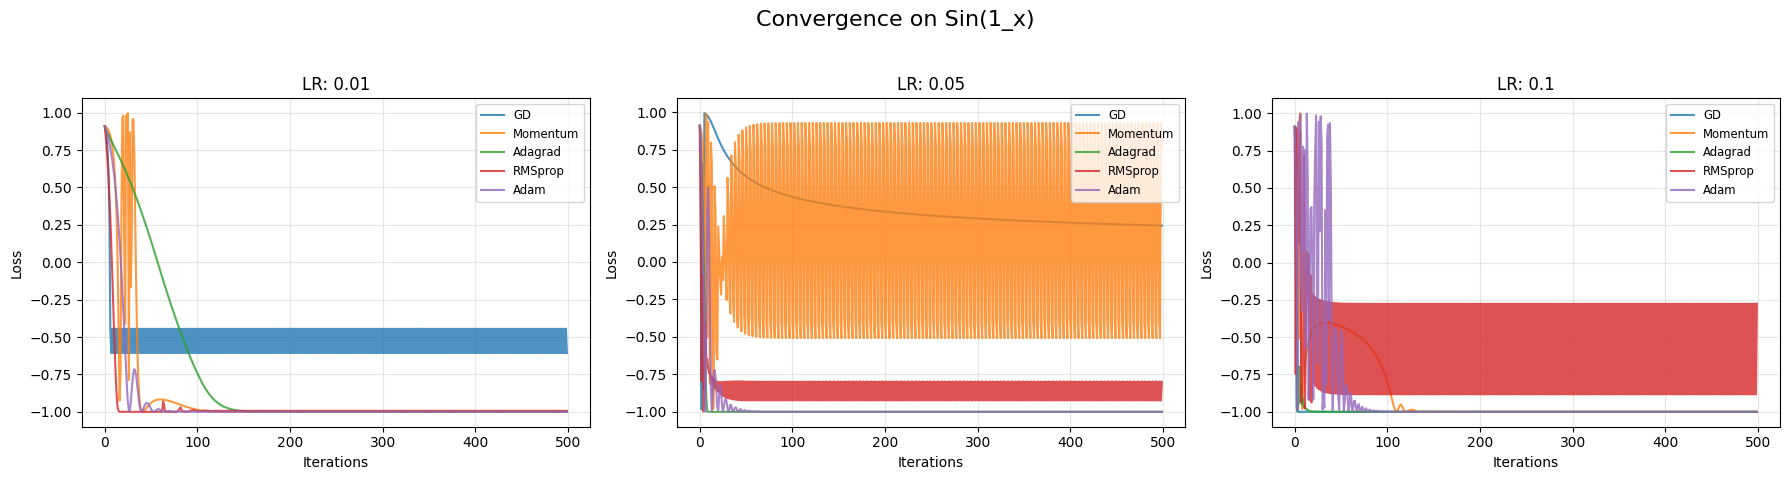

Optimizer  | LR    | Loss       | Result
--------------------------------------------------
GD         | 0.01  | -0.6074    | [0.278]
Momentum   | 0.01  | -1.0000    | [-0.637]
Adagrad    | 0.01  | -1.0000    | [0.212]
RMSprop    | 0.01  | -0.9944    | [0.218]
Adam       | 0.01  | -1.0000    | [0.212]
GD         | 0.05  | 0.2425     | [4.085]
Momentum   | 0.05  | 0.7751     | [-0.149]
Adagrad    | 0.05  | -1.0000    | [0.212]
RMSprop    | 0.05  | -0.8002    | [0.196]
Adam       | 0.05  | -1.0000    | [0.212]
GD         | 0.1   | -1.0000    | [-0.637]
Momentum   | 0.1   | -1.0000    | [-0.637]
Adagrad    | 0.1   | -1.0000    | [0.212]
RMSprop    | 0.1   | -0.2758    | [0.192]
Adam       | 0.1   | -1.0000    | [0.212]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# --- 1. Define Functions and Gradients ---

def rosenbrock(w):
    x, y = w[0], w[1]
    # Safety check to prevent overflow errors during calculation
    if abs(x) > 1e4 or abs(y) > 1e4:
        return np.inf
    return (1 - x)**2 + 100 * (y - x**2)**2

def rosenbrock_grad(w):
    x, y = w[0], w[1]
    # Safety check
    if abs(x) > 1e4 or abs(y) > 1e4:
        return np.array([0.0, 0.0])

    grad_x = -2 * (1 - x) - 400 * x * (y - x**2)
    grad_y = 200 * (y - x**2)
    return np.array([grad_x, grad_y])

def sin_inv(w):
    x = w[0]
    if np.isclose(x, 0, atol=1e-8):
        return 0.0
    return np.sin(1/x)

def sin_inv_grad(w):
    x = w[0]
    if np.isclose(x, 0, atol=1e-8):
        return np.array([0.0])

    # Chain rule: cos(1/x) * (-1/x^2)
    # We clip the inner calc to prevent explosion near 0
    try:
        val = -1 / (x**2)
        # Soft clipping the derivative magnitude for stability
        if abs(val) > 1e6:
            val = np.sign(val) * 1e6
        grad = np.cos(1/x) * val
    except:
        grad = 0.0
    return np.array([grad])

# --- 2. Define Optimizers ---

class Optimizer:
    def __init__(self, lr=0.01):
        self.lr = lr
    def step(self, w, grad):
        return w

class GradientDescent(Optimizer):
    def step(self, w, grad):
        return w - self.lr * grad

class SGD_Momentum(Optimizer):
    def __init__(self, lr=0.01, beta=0.9):
        super().__init__(lr)
        self.beta = beta
        self.v = 0
    def step(self, w, grad):
        self.v = self.beta * self.v + (1 - self.beta) * grad
        return w - self.lr * self.v

class Adagrad(Optimizer):
    def __init__(self, lr=0.01, epsilon=1e-8):
        super().__init__(lr)
        self.epsilon = epsilon
        self.cache = 0
    def step(self, w, grad):
        self.cache += grad**2
        return w - (self.lr / (np.sqrt(self.cache) + self.epsilon)) * grad

class RMSprop(Optimizer):
    def __init__(self, lr=0.01, beta=0.9, epsilon=1e-8):
        super().__init__(lr)
        self.beta = beta
        self.epsilon = epsilon
        self.cache = 0
    def step(self, w, grad):
        self.cache = self.beta * self.cache + (1 - self.beta) * (grad**2)
        return w - (self.lr / (np.sqrt(self.cache) + self.epsilon)) * grad

class Adam(Optimizer):
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = 0
        self.v = 0
        self.t = 0
    def step(self, w, grad):
        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grad**2)

        m_hat = self.m / (1 - self.beta1**self.t)
        v_hat = self.v / (1 - self.beta2**self.t)

        return w - (self.lr / (np.sqrt(v_hat) + self.epsilon)) * m_hat

# --- 3. Training Loop ---

def run_optimization(func, grad_func, optimizer_class, lr, start_point, iterations=2000):
    opt = optimizer_class(lr=lr)
    w = np.array(start_point, dtype=float)
    history_loss = []
    start_time = time.time()

    for i in range(iterations):
        loss = func(w)

        # Stop if diverged
        if np.isinf(loss) or np.isnan(loss) or loss > 1e10:
            history_loss.append(1e10) # Append a cap value for plotting
            break

        history_loss.append(loss)

        grad = grad_func(w)

        # --- KEY FIX: Gradient Clipping ---
        # If gradient is too large, scale it down to keep updates stable
        grad_norm = np.linalg.norm(grad)
        if grad_norm > 10.0:
            grad = grad * (10.0 / grad_norm)
        # ----------------------------------

        w = opt.step(w, grad)

    end_time = time.time()
    return w, history_loss, end_time - start_time

# --- 4. Execution & Visualization ---

functions_config = [
    {
        "name": "Rosenbrock",
        "func": rosenbrock,
        "grad": rosenbrock_grad,
        "start": [-1.0, 2.0],
        "iters": 1500
    },
    {
        "name": "Sin(1_x)",
        "func": sin_inv,
        "grad": sin_inv_grad,
        "start": [0.5],
        "iters": 500
    }
]

lrs = [0.01, 0.05, 0.1]
optimizers_list = [
    ("GD", GradientDescent),
    ("Momentum", SGD_Momentum),
    ("Adagrad", Adagrad),
    ("RMSprop", RMSprop),
    ("Adam", Adam)
]

for config in functions_config:
    print(f"\n--- Optimization for {config['name']} ---")
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Convergence on {config["name"]}', fontsize=16)

    results_table = []

    for i, lr in enumerate(lrs):
        ax = axes[i]
        ax.set_title(f'LR: {lr}')
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Loss')

        for opt_name, opt_class in optimizers_list:
            final_w, loss_hist, duration = run_optimization(
                config['func'],
                config['grad'],
                opt_class,
                lr,
                config['start'],
                config['iters']
            )

            # Filter Plotting Data
            # Matplotlib crashes on 'inf', so we replace inf with NaN for plotting
            safe_loss = np.array(loss_hist)
            safe_loss[safe_loss > 1e10] = np.nan

            ax.plot(safe_loss, label=opt_name, linewidth=1.5, alpha=0.8)

            results_table.append({
                "Optimizer": opt_name,
                "LR": lr,
                "Time": duration,
                "Final Loss": loss_hist[-1] if loss_hist else float('inf'),
                "Final x": final_w
            })

        ax.legend(loc='upper right', fontsize='small')
        ax.grid(True, alpha=0.3)

        # Log scale only for Rosenbrock and if valid data exists
        if config["name"] == "Rosenbrock":
            try:
                ax.set_yscale('log')
            except:
                pass

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Simple Text Report
    print(f"{'Optimizer':<10} | {'LR':<5} | {'Loss':<10} | {'Result'}")
    print("-" * 50)
    for res in results_table:
        # Format output safely
        f_loss = f"{res['Final Loss']:.4f}" if res['Final Loss'] < 1e5 else "DIV"
        f_x = str(np.round(res['Final x'], 3))
        print(f"{res['Optimizer']:<10} | {res['LR']:<5} | {f_loss:<10} | {f_x}")